This is the 2nd part (Future senaria) of bias correction of the hail predictor variables from LENS2 using quantile-quantile mapping of ERA5 

Removing the systematic bias between the ERA5 data and the forecast/projection quantile distributions of LENS2. The idea behind this technique is to calibrate the forecast/projection distribution with the ERA5 distribution by adjusting the forecast/projection values.

The bias correct is per grid point and use a 31-day running window. 
Use the Replace mapping for current climate. This is the 2nd part, using Delta QM for future climate.
- Grid/Temporal interopolation/aligment
- For each model value, get its percentile on the CDF of the model,then apply it to get a value from the reference ERA5 dataset and reference current model dataset.
- Bias Adjustment: taking the difference between ref_dataset and model_present at each percentile as a kind of systematic bias (delta)
    and add them to model_future at the same percentile.
 
Ming Ge Aug 2024

Reference:
 - Technical Note: Bias correcting climate model simulated daily temperature extremes with quantile mapping <br>
https://hess.copernicus.org/articles/16/3309/2012/hess-16-3309-2012.pdf
- Quantile Mapping Bias Correction <br>
https://medium.com/@juanmi.gutierrez/quantile-mapping-bias-correction-63ed01d5a618#:~:text=Quantile%20mapping%20works%20by%20removing,adjusting%20the%20forecast%2Fprojection%20values
- Explain Quantile Mapping Bias Correction with Python code
https://www.linkedin.com/pulse/explain-quantile-mapping-bias-correction-python-code-chonghua-yin  

https://journals.ametsoc.org/view/journals/clim/28/17/jcli-d-14-00754.1.xml

https://www.nature.com/articles/s41597-021-01079-3
Bias-corrected CMIP6 global dataset for dynamical downscaling of the historical and future climate (1979–2100)

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023GL105979
Is Bias Correction in Dynamical Downscaling Defensible?

https://www.nature.com/articles/s41597-019-0343-8
High-resolution and bias-corrected CMIP5 projections for climate change impact assessments

https://www.tandfonline.com/doi/full/10.1080/02626667.2023.2201450#abstract
Bias adjustment to preserve changes in variability: the unbiased mapping of GCM
changes
                                                    

In [2]:
import numpy
import datetime
import os
import glob
from calendar import isleap
from tqdm import tqdm
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm, gamma, erlang, expon
from scipy.stats import percentileofscore
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
def bias_correction_future_my(ref_dataset, model_present, model_future):
    '''
    Remove the biases for each quantile value taking the difference between 
    ref_dataset and model_present at each percentile as a kind of systematic bias (delta)
    and add them to model_future at the same percentile.

    returns: downscaled future_value
    '''
    
    model_future_corrected = np.zeros(model_future.shape[0])
     
    for ival, model_value in enumerate(model_future[:,15]):
        if np.isnan(model_value):
            model_future_corrected[ival] = model_value
        else:
            percentile = percentileofscore(model_future.ravel(), model_value, nan_policy = 'omit')
            if percentile >100:
                model_future_corrected[ival] = model_value + ref_dataset.max()-model_present.max()
            else:
                model_future_corrected[ival] = model_value + np.nanpercentile(
                ref_dataset, percentile) - np.nanpercentile(model_present, percentile)
        
    return model_future_corrected

In [4]:
def bias_correction_future(ref_dataset, model_present, model_future):
    '''
    Remove the biases for each quantile value taking the difference between 
    ref_dataset and model_present at each percentile as a kind of systematic bias (delta)
    and add them to model_future at the same percentile.

    returns: downscaled future_value
    '''
    
    model_future_corrected = np.zeros(model_future.size)
     
    for ival, model_value in enumerate(model_future):
        if np.isnan(model_value):
            model_future_corrected[ival] = model_value
        else:
            percentile = percentileofscore(model_future, model_value, nan_policy = 'omit')
        
            model_future_corrected[ival] = model_value + np.percentile(
                ref_dataset, percentile) - np.percentile(model_present, percentile)
    #print(model_present_corrected )        
    return model_future_corrected

In [5]:
# https://medium.com/@juanmi.gutierrez/quantile-mapping-bias-correction-63ed01d5a618#:~:text=Quantile%20mapping%20works%20by%20removing,adjusting%20the%20forecast%2Fprojection%20values.
# Quantile Mapping Bias Correction
def eQM_porcentual_delta(ref_dataset, model_present, model_future):
        """
        The eQM Delta-proportion method assumes that the proportional difference 
        between the downscaled and observed value during the period of observed 
        data applies as a systematic bias to the future period as well.

        returns: downscaled model_present and model_future        
        """
   
        model_present_corrected = np.zeros(model_present.size)  
        model_future_corrected = np.zeros(model_future.size)

        for ival, model_value in enumerate(model_present):
            percentile = percentileofscore(model_present, model_value)
            percentile_ref = np.percentile(ref_dataset, percentile)
            dif = (percentile_ref - model_value)/model_value
            model_present_corrected[ival] = model_value*(1+dif)
            model_future_corrected[ival] = model_future[ival]*(1+dif)
            
        return model_present_corrected, model_future_corrected


#### setups

In [6]:
year_s = 2015
year_e = 2100
 
n_year = year_e - year_s + 1

time_6h = pd.date_range(datetime.datetime(year_s, 1, 1, 0),
                     end=datetime.datetime(year_e, 12, 31, 23), freq='6h')

# variables from ERA5
# /glade/u/home/prein/projects/2024/2024_ML-Hail-Model/programs/    Boris_code  LENS2_evaluation
# from /glade/u/home/prein/projects/2023/2023_Boris-Hail/programs
dir_lens = '/glade/campaign/mmm/c3we/mingge/LENS2/6hr/'
dir_o    = '/glade/campaign/mmm/c3we/mingge/QBE/'

years = np.unique(time_6h.year)
iMonths = np.unique(time_6h.month)

lens_var_names = ['CAPEmax',
                'FLH',
                'CINmax',
                'VS06',
                'TotalTotal',
                'RH850']
n_var = len(lens_var_names)

#### 1 Read current ERA5 and LENS2 data used to BC

In [6]:
%%time
# read regridded reorganzied ERA5
flnm_e5_31win = dir_o + 'hailpredictors_e5_31window.nc'
print(flnm_e5_31win)
with xr.open_dataset(flnm_e5_31win) as ds:
    lat_lens = ds.lat
    lon_lens = ds.lon
    n_lat = len(lat_lens)
    n_lon = len(lon_lens)
    e5_31win = ds.hailpredictors.data  # (55, 365, 31, 6, 28, 48)

# nm = 1-10
nm = 1
mem_s = str(nm).zfill(2)
flnm_lens_31win = dir_o + 'hailpredictors_lens_31window_' + mem_s + '.nc'
print(flnm_lens_31win)
with xr.open_dataset(flnm_lens_31win) as ds:
    lens_31win = ds.hailpredictors.data #(55, 365, 31, 28, 48, 6)

/glade/campaign/mmm/c3we/mingge/QBE/hailpredictors_e5_31window.nc
/glade/campaign/mmm/c3we/mingge/QBE/hailpredictors_lens_31window_01.nc
CPU times: user 1.48 s, sys: 38.3 s, total: 39.8 s
Wall time: 46.6 s


#### 2 Preparing BC

In [ ]:
%%time
# For each day of the year, a moving window of ±15 days is used 
# to select all candidate days representative of the date of future senario
# The following part is too time consumming, I leave it to a array job
# of python script:
# and all of these candidate days are sorted and ranked to produce 
# for each calendar day two cumulative distribution functions (CDFs):
# one for observations and one for the GCM.  
# select candidate data with 31-day running windows
 
window_size = 31
win_half = 15
win_half_p1 = window_size - win_half

for yy in range(year_s, year_e, 10): 
    if yy != 2095:
        n_yy = 10
    else:  # 6 years
        n_yy = 6
    
    # find the correct file for this year
    # files = glob.glob(dir_lens+str(yy)+'010100-*_LENS2_HailPredictors_'+str(nm).zfill(3)+'.nc')
    files = glob.glob(dir_o + 'hailpredictors_lens_31window_'+str(yy)+'010100-*'+mem_s+'.nc')
    
    if len(files) != 0: 
        flnm_o = dir_o + 'hailpredictors_' + str(yy) + '-' + str(yy+n_yy-1) + 'lens_' + mem_s + '_corrected.nc'
             
        if os.path.isfile(flnm_o) == False: 
            file = files[0]
            print(file) 

            with xr.open_dataset(file) as ds:
                lens_31win_f = ds.hailpredictors.data
            
            lens_daymax_f = lens_31win_f[:,:,15,:,:,:]
            
            # create a new array with the same shape and type as a given array.
            lens2_corrected = np.empty(lens_daymax_f.shape)
             
            for nv in range(n_var):
                for nlat in range(n_lat):
                    print(nv, nlat)
                    for nlon in range(n_lon):
                        for nd in range(365):
                            lens2_corrected[:, nd, nlat, nlon, nv] = bias_correction_future_my(
                                        e5_31win    [:, nd, :, nv, nlat, nlon].ravel(),
                                        lens_31win  [:, nd, :, nlat, nlon, nv].ravel(),
                                        lens_31win_f[:, nd, :, nlat, nlon, nv])
                                    
            da_cor = xr.DataArray(lens2_corrected, coords=[np.arange(yy, yy+n_yy, 1), 
                                                 np.arange(1, 366,1),
                                                 lat_lens,
                                                 lon_lens,
                                                 lens_var_names],
                               dims=['year', 'Julian_day', 'lat', 'lon', 'variable'])

            ds = da_cor.to_dataset(name='hailpredictors')
            ds.to_netcdf( path = flnm_o)
            print(flnm_o)


In [ ]:
To spead up, I use job_array_BC_future.pbs (bias_correction_lens2_future.py) for 10 ensemble members

#### Check corrected dataset

(2, 28, 48, 6)

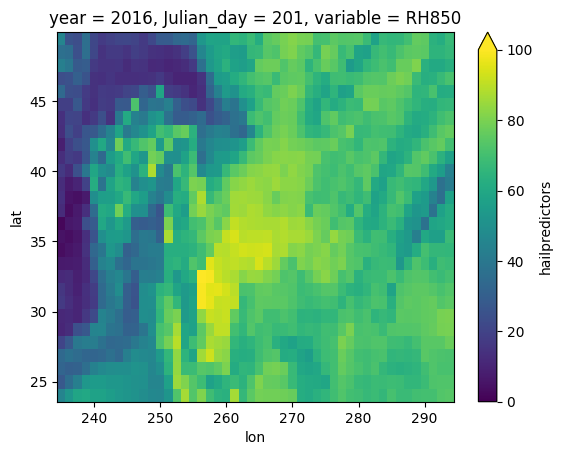

In [22]:
flnm_cre = dir_o + 'hailpredictors_2015-2024lens_01_corrected.nc'
flnm_org = '/glade/campaign/mmm/c3we/mingge/QBE/hailpredictors_lens_31window_2015010100-2024123100_01.nc'

# I radomly chose 2016  Julian day = 201
with xr.open_dataset(flnm_org) as ds:
    data_1 = ds.hailpredictors[1,200,15,:,:,:]
    #data_1[:,:,5].plot(vmin=0, vmax=100)
with xr.open_dataset(flnm_cre) as ds:
    data_2 = ds.hailpredictors[1,200,:,:,:]
    #data_2[:,:,5].plot(vmin=0, vmax=100)

# Stack the arrays along a new dimension (axis=0)
stacked_data = np.stack((data_1.data, data_2.data), axis=0)
stacked_data.shape

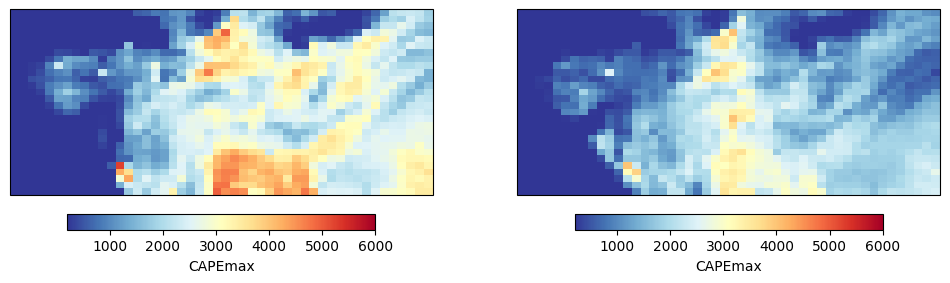

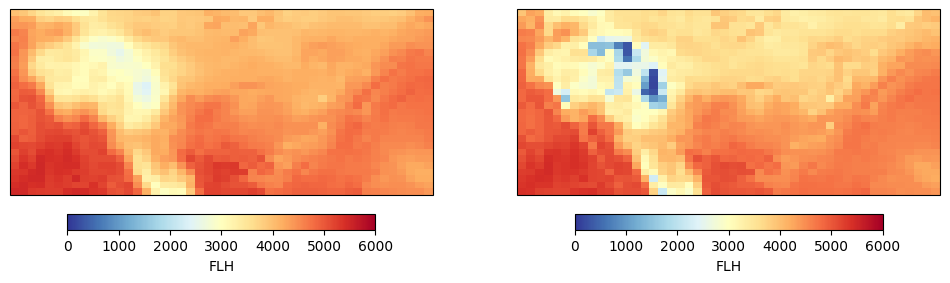

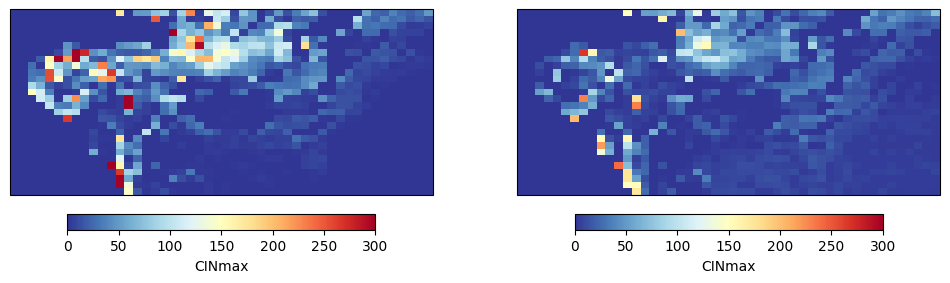

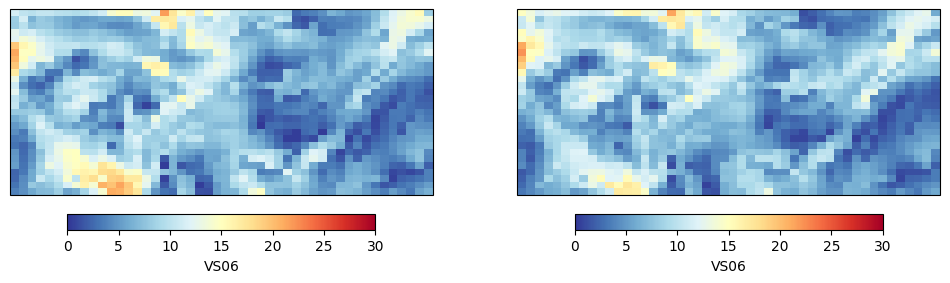

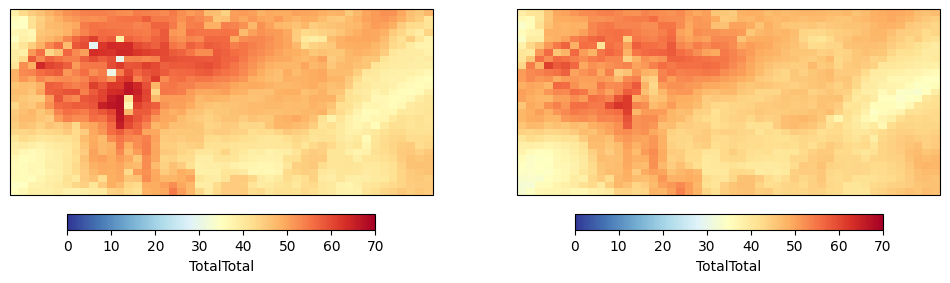

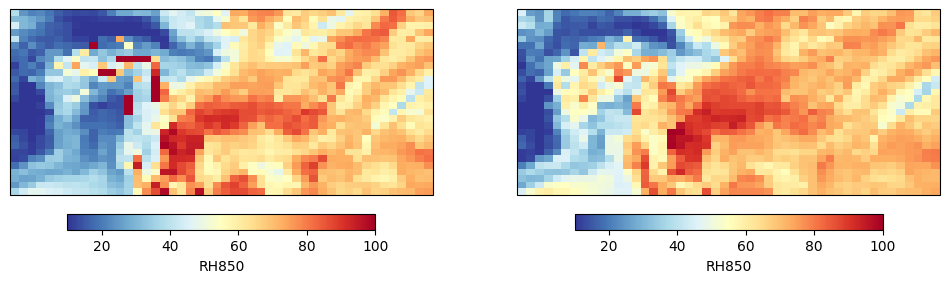

In [20]:
def plot_mesh_p2(lat, lon, data, color_map, var_s, vmin, vmax):
    
    fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()},
                          figsize=(12, 5))
    title_s = ['before BC', 'after BC']
    for nn in range(2):
        # Make a filled contour plot
        ''' 
        filled_c = ax[nn].contourf(lon, lat, data[nn],
                           extend='both', levels =np.arange(vmin, vmax, (vmax-vmin)/10), 
                           cmap = color_map, transform = ccrs.PlateCarree())       
        
        ax[nn].coastlines()
        ax[nn].add_feature(cfeature.STATES, zorder=1, linewidth=.3, edgecolor='black')
        ax[nn].set_title(title_s[nn])
        ax[nn].set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())
        ax[nn] = plt.gca()
        
        # Add a colorbar for the filled contour.
        # and pad argument to set colorbar away from x-axis
        fig.colorbar(filled_c,  label= var_s, pad = 0.05, fraction=0.04, orientation="horizontal"); 
        #fig.colorbar(filled_c,   shrink=0.9, orientation="horizontal")
        '''
        im = ax[nn].pcolormesh(lon, lat, data[nn], vmin = vmin, vmax = vmax, cmap=color_map, shading='auto',rasterized=True)
        fig.colorbar(im,ax=ax[nn],  label= var_s, pad = 0.05, fraction=0.04, orientation="horizontal")
        
vmin = [200,    0,  0,   0,  0,   10 ]
vmax = [6000, 6000, 300, 30, 70, 100]
for nv in range(n_var):
    plot_mesh_p2(ds.lat, ds.lon, stacked_data[:,:,:,nv], 'RdYlBu_r', lens_var_names[nv], vmin[nv], vmax[nv])
    

### FINISHED

In [ ]:
# set some plotting parameters for each variable
# ['CAPEmax', 'FLH', 'CINmax', 'VS06', 'TotalTotals', 'RH850']
vmin = [0,1000,0,0,25,0]
vmax = [1500,4000,50,25,50,70]
units = ['J/kg','m','J/kg','m/s','K','%']

fig = plt.figure(figsize=(16, 16))
plt.rcParams.update({"font.size": 13})
gs1 = gridspec.GridSpec(n_var, 3)
gs1.update(left=0.04, right=0.96, bottom=0.08, top=0.95, wspace=0.25, hspace=0.1)

datasets = ['ERA5', 'LENS2', 'diff.']
for va in tqdm(range(n_var)):
    for da in range(len(datasets)):
        ax = plt.subplot(gs1[va, da], projection=ccrs.PlateCarree())
            
        # Plot data
        if da == 0:
            data_act = np.mean(rgrERAVarall[:,va,:,:], axis=0)
        if da == 1:
            data_act = np.mean(lens_daymax[:,:,:,va,0], axis=0)
        if da == 2:
            data_act = np.mean(lens_daymax[:,:,:,va,0], axis=0) - np.mean(rgrERAVarall[:,va,:,:], axis=0)

        if da != 2:
            cs = plt.pcolormesh(lon_lens, lat_lens, data_act,
                      cmap='rainbow', transform=ccrs.PlateCarree(),
                      vmin = vmin[va], vmax = vmax[va])
        if da == 2:
            cs = plt.pcolormesh(lon_lens, lat_lens, data_act,
                      cmap='coolwarm', transform=ccrs.PlateCarree(),
                      vmin = -vmax[va]/2, vmax = vmax[va]/2)
        
        # Add coastlines and borders
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=0.5)
        # Add US states
        ax.add_feature(cfeature.STATES, linestyle='-', edgecolor='black', alpha=0.5)
        
        # Set extent to North America
        ax.set_extent([-127, -66, 24, 50], crs=ccrs.PlateCarree())
        
        # # Add gridlines
        # ax.gridlines(draw_labels=True)
        
        # Title
        plt.title(datasets[da] +') '+ lens_var_names[va]+' ['+units[va]+']')

        # Add a colorbar
        if da == 0:
            pos1 = ax.get_position()
            CbarAx = plt.axes([-0.025, ax.get_position().y0, 0.005, ax.get_position().y1 - ax.get_position().y0])
            cb = plt.colorbar(cs, cax = CbarAx, orientation='vertical', extend='both', label='['+units[va]+']')
            cb.ax.tick_params(labelsize=14)
        if da == 2:
            pos1 = ax.get_position()
            CbarAx = plt.axes([0.99, ax.get_position().y0, 0.005, ax.get_position().y1 - ax.get_position().y0])
            cb = plt.colorbar(cs, cax = CbarAx, orientation='vertical', extend='both', label='['+units[va]+']')
            cb.ax.tick_params(labelsize=14)
    

plt.show()
# fig.savefig(sSaveDataDir+'Map-hail-frequency_'+var_string_+'_'+str(ii).zfill(2)+'.pdf', bbox_inches='tight') #, dpi=700)

#### check NaN

In [17]:
# NaN in VS06 6000m wind shear
# from u6k= np.float32(wrf.interplevel(u_4d, h_4d_new, 6000, meta=False)) ??
# no Nan in U, V, H
flnm = '/glade/campaign/mmm/c3we/mingge/LENS2/6hr/2015010100-2024123100_LENS2_HailPredictors_001.nc'
with xr.open_dataset(flnm) as ds:
    ii = 7300+28*4+3
    data = ds.VS06[ii-3:ii+3, 25, 2].data 
    vs = ds.VS06.data
    # print(*lens_daymax[5,28,:,:,3])
    print(data)
    #print(ds)

# Count number of NaN in dataset
'There are ', np.isnan(vs).sum(), 'NaN'

[10.399252   2.5663593  3.869757         nan 20.644234  27.28666  ]


('There are ', 3, 'NaN')

In [ ]:
dir_data = '/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/hour_6/'
flnm = dir_data + 'Z3/b.e21.BSSP370smbb.f09_g17.LE2-1011.001.cam.h5.Z3.2015010100-2024123100.nc'
with xr.open_dataset(flnm) as ds:
    data = ds.Z3.data
'There are ', np.isnan(data).sum(), 'NaN'

In [ ]:
flnm = dir_data + 'U/b.e21.BSSP370smbb.f09_g17.LE2-1011.001.cam.h5.U.2015010100-2024123100.nc'
with xr.open_dataset(flnm) as ds:
    data = ds.U.data
    #np.count_nonzero(~np.isnan(data))
'There are ',np.isnan(data).sum() , 'NaN'


In [ ]:
flnm = dir_data + 'V/b.e21.BSSP370smbb.f09_g17.LE2-1011.001.cam.h5.V.2015010100-2024123100.nc'
with xr.open_dataset(flnm) as ds:
    data = ds.V.data
'There are ', np.isnan(data).sum(), 'NaN'